In [34]:
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import scipy.stats as st

In [ ]:
%matplotlib inline

In [131]:
#####################################################
# input file names and model parameters: edit these
#####################################################

# prefix for pickle files
train_name = "samplePubMed1"
val_name = "samplePubMed1"
# test_name = "samplePubMed1"

# test on samplepubmed2
test_name = "samplePubMed2"

# type of model: either 'regression' or 'classification'
# model_type = 'regression'
model_type = 'classification'

# other hyperparameters
learning_rate = 0.001
# number of iterations for training
training_steps = 100 #100000
# number of iterations for printing out minibatch loss
display_step = 10 # 5000
# number of hidden layers in lstm cell
num_hidden = 64
# intermediate activation function: 
    # either tf.nn.tanh or tf.nn.relu or tf.nn.softmax
act_fn = tf.nn.tanh

In [111]:
##################################################################

In [112]:
# read in pickle training data
train_data = pickle.load( open( "data/" + train_name + "_train_data.p", "rb" ) )
train_labels = pickle.load( open( "data/" + train_name + "_train_labels.p", "rb" ) )

In [113]:
##################################################################

In [114]:
# other network parameters
num_input = 4 # len of one hot encoded nt
timesteps = 23 # len of seq
forget_b = 1
batch_size = 1 # don't change this
if model_type == 'regression':
    num_classes = 1
else:
    num_classes = 21

In [115]:
# reset graph
tf.reset_default_graph() 

# tf graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_classes])

# define weights
weights = {
    # Hidden layer weights => 2*n_hidden because of forward + backward cells
    'out': tf.get_variable("my_int_variable", [2*num_hidden, num_classes],
  initializer=tf.glorot_uniform_initializer(seed = 23))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# biRNN model
def BiRNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, num_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, num_input)
    x = tf.unstack(x, timesteps, 1)

    # Forward direction cell
    lstm_fw_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=forget_b, activation=act_fn)
    # Backward direction cell
    lstm_bw_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=forget_b, activation=act_fn)

    # Get lstm cell output
    try:
        outputs, _, _ = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                              dtype=tf.float32)
    except Exception: # Old TensorFlow version only returns outputs not states
        outputs = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                        dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    out = tf.matmul(outputs[-1], weights['out']) + biases['out']
    
    if model_type == "regression":
        # sigmoid result to get output in range [0,1]
        return tf.nn.sigmoid(out)
    else:
        return out

# pass through rnn to get predicted effect
prediction = BiRNN(X, weights, biases)

# define loss and optimizer

if model_type == "regression":
    # use mse
    loss_op = tf.reduce_mean(tf.losses.mean_squared_error(labels=Y, predictions=prediction))
else:
    # use bce
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=Y))
    
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# for classification, predicted label is argmax
if model_type == "classification":
    prediction = tf.argmax(tf.nn.softmax(prediction), 1)
    correct_pred = tf.equal(prediction, tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
else:
    accuracy = tf.reduce_mean(tf.losses.mean_squared_error(Y, prediction))

# init variables
init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [116]:
def get_batch(batch_size, x, y):
    i = np.random.randint(0,x.shape[0], size=(batch_size))
    return np.array(x[i]), np.array(y[i])

In [117]:
##################################################################

In [118]:
###############
# train model
###############
saver = tf.train.Saver()


# start training
with tf.Session() as sess:

    # run the initializer
    sess.run(init)
    
    # things to save during display step + val step
    train_losses = []
    val_losses = []
    
    
    for step in range(1, training_steps+1):
        batch_x, batch_y = get_batch(batch_size, train_data, train_labels)
        
        # reshape for regression
        if model_type == "regression":
            batch_x = batch_x.reshape((batch_size, timesteps, num_input))
            batch_y = batch_y.reshape((batch_size, num_classes))

        # Run optimization op (backprop) in every training step
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        
        # in display step, calc train_losses
        if step % display_step == 0 or step == 1:
            t_loss = sess.run(loss_op, feed_dict={X: batch_x, Y: batch_y})
            train_losses.append(t_loss)
        
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(t_loss))
        
    print("Optimization Finished!")
    saver.save(sess, "data/model.ckpt")

Step 1, Minibatch Loss= 3.1060
Step 10, Minibatch Loss= 2.0854
Step 20, Minibatch Loss= 4.3531
Step 30, Minibatch Loss= 1.9523
Step 40, Minibatch Loss= 2.5471
Step 50, Minibatch Loss= 2.0625
Step 60, Minibatch Loss= 3.7310
Step 70, Minibatch Loss= 2.2899
Step 80, Minibatch Loss= 3.2463
Step 90, Minibatch Loss= 4.0926
Step 100, Minibatch Loss= 3.5709
Optimization Finished!


In [119]:
##################################################################

In [120]:
# read in validation data
val_data = pickle.load( open( "data/" + val_name + "_val_data.p", "rb" ) )
val_labels = pickle.load( open( "data/" + val_name + "_val_labels.p", "rb" ) )

In [121]:
###############################################
# predictions and accuracy for validation set
###############################################

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "data/model.ckpt")

    # Calculate accuracy and predictions for validation set
    val_preds = []
    val_accs_final = []
    val_losses_final = []

    for i in range(val_labels.shape[0]/batch_size):
        x = val_data[i*batch_size: i*batch_size + batch_size].reshape((batch_size,timesteps, num_input))
        y = val_labels[i*batch_size:i*batch_size + batch_size].reshape((batch_size,num_classes))
        val_preds.append(sess.run(prediction, feed_dict={X: x}))      
        val_accs_final.append(sess.run(accuracy, feed_dict={X: x, Y:y}))
        val_losses_final.append(sess.run(loss_op, feed_dict={X: x, Y:y}))
    
    val_acc_f = np.mean(val_accs_final)
    val_loss_f = np.mean(val_losses_final)
    
    print("Final Validtion Accuracy = " + "{:.4f}".format(val_acc_f))
    print("Final Validation Loss = " + "{:.4f}".format(val_loss_f))


INFO:tensorflow:Restoring parameters from data/model.ckpt
Final Validtion Accuracy = 0.0000
Final Validation Loss = 3.5161


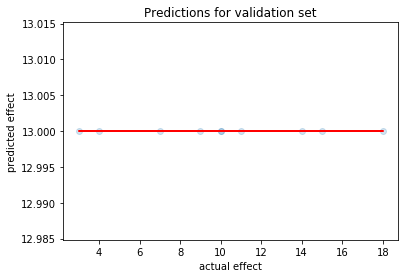

In [130]:
################
# plot for val
################
vpreds = [v[0] for v in val_preds]
vpreds = np.array(vpreds).reshape(len(vpreds),)

if model_type == "regression":
    vl = val_labels.reshape(val_labels.shape[0],)
else:
    # take argmax for classification
    vl = np.argmax(val_labels, axis=1)
    vl.reshape(vl.shape[0],)

plt.scatter(vl, vpreds, alpha=0.2)

z = np.polyfit(vl,vpreds,1)
p = np.poly1d(z)
plt.plot(vl, p(vl), "r")

plt.ylabel("predicted effect")
plt.xlabel("actual effect")
plt.title("Predictions for validation set")

plt.show()

In [123]:
# calculate spearman corr for val data
st.spearmanr(vpreds, vl)

/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


SpearmanrResult(correlation=nan, pvalue=nan)

In [124]:
# output prediction and true labels for val
pv_fname = "results/val_preds.csv"
pred_vlabels = np.vstack((vpreds, vl)).T
np.savetxt(pv_fname, pred_vlabels, delimiter=",", header="Predictions,Labels")

In [125]:
##################################################################

In [132]:
# read in test data
test_data = pickle.load( open( "data/" + test_name + "_test_data.p", "rb" ) )
test_labels = pickle.load( open( "data/" + test_name + "_test_labels.p", "rb" ) )

In [133]:
############################################
# predictions and accuracy for testing set
############################################

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "data/model.ckpt")

    # Calculate accuracy and predictions for validation set
    test_preds = []
    test_accs_final = []
    test_losses_final = []

    for i in range(test_labels.shape[0]/batch_size):
        x = test_data[i*batch_size: i*batch_size + batch_size].reshape((batch_size,timesteps, num_input))
        y = test_labels[i*batch_size:i*batch_size + batch_size].reshape((batch_size,num_classes))
        test_preds.append(sess.run(prediction, feed_dict={X: x}))      
        test_accs_final.append(sess.run(accuracy, feed_dict={X: x, Y:y}))
        test_losses_final.append(sess.run(loss_op, feed_dict={X: x, Y:y}))
    
    test_acc_f = np.mean(test_accs_final)
    test_loss_f = np.mean(test_losses_final)
    
    print("Final Test Accuracy = " + "{:.4f}".format(test_acc_f))
    print("Final Test Loss = " + "{:.4f}".format(test_loss_f))

INFO:tensorflow:Restoring parameters from data/model.ckpt
Final Test Accuracy = 0.0000
Final Test Loss = 3.4924


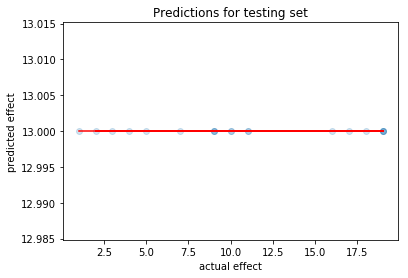

In [134]:
#################
# plot for test
#################
# plot for test
tpreds = [v[0] for v in test_preds]
tpreds = np.array(tpreds).reshape(len(tpreds),)

if model_type == "regression":
    tl = test_labels.reshape(test_labels.shape[0],)
else:
    # take argmax for classification
    tl = np.argmax(test_labels, axis=1)
    tl.reshape(tl.shape[0],)


plt.scatter(tl, tpreds, alpha=0.2)

z = np.polyfit(tl, tpreds, 1)
p = np.poly1d(z)
plt.plot(tl, p(tl), "r")

plt.title("Predictions for testing set")
plt.ylabel("predicted effect")
plt.xlabel("actual effect")

plt.show()

In [135]:
# calculate spearman corr for test data
st.spearmanr(tpreds, tl)

SpearmanrResult(correlation=nan, pvalue=nan)

In [136]:
# output prediction and true labels for test
pt_fname = "results/test_preds.csv"
pred_tlabels = np.vstack((tpreds, tl)).T
np.savetxt(pt_fname, pred_tlabels, delimiter=",", header="Predictions,Labels")

In [137]:
##################################################################

Text(0.5,1,'Training loss over time')

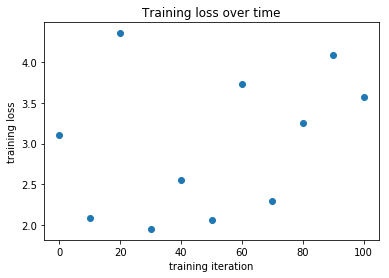

In [138]:
# plot training loss over time
plt.scatter(np.arange(0, training_steps+display_step, display_step), train_losses)
plt.xlabel("training iteration")
plt.ylabel("training loss")
plt.title("Training loss over time")

In [139]:
# output training loss over time
tl_fname = "results/train_loss.csv"
train_loss_time = np.vstack((np.arange(0, training_steps+display_step, display_step), train_losses)).T
np.savetxt(tl_fname, train_loss_time, delimiter=",", header="Time,Training Loss")